# Métodos e Modelos Avançados em Ciência de Dados

## Uso de PSO

### Ajuste de Hiperparâmetros

PSO:
https://pyswarms.readthedocs.io/en/latest/api/_pyswarms.optimizers.html

Algoritmo de classificação:
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

Dataset:
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

In [333]:
# import da classe do algoritmo de classificação
from sklearn.tree import DecisionTreeClassifier

# import da classe para normalização dos dados
from sklearn.preprocessing import StandardScaler

#import da classe do algoritmo de otimização de enxame de partículas
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history

# import das metodologias de experientação
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

# import das biblitecas para manipulação dos dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from statistics import mean
from collections import defaultdict

# import do datest
from sklearn.datasets import load_breast_cancer

In [334]:
# carregando os dados do dataset
X, y = load_breast_cancer(return_X_y=True)

print("X: ", X.shape)
print("y: ", y.shape)

X:  (569, 30)
y:  (569,)


In [335]:
# convertendo para um Dataframe e exibindo os primeiros registros
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [336]:
# seed para reprodução dos experimentos
seed = 30
random.seed(seed)
np.random.seed(seed)

# dividindo e atribuindo os dados de treino e teste (70% treino e 30% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=seed, 
    shuffle=True,
    stratify=y
)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ",y_test.shape)

X_train:  (398, 30)
y_train:  (398,)
X_test:  (171, 30)
y_test:  (171,)


In [337]:
# normalizando os dados de treino e teste
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [338]:
# treinando o algoritmo decision tree com os hiperparâmetros default
tree = DecisionTreeClassifier(random_state=seed) 
tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=30)

In [339]:
# exibindo a acurácia do algoritmo decision tree no conjunto de treino e teste com os hiperparâmetros default
y_train_pred_default = tree.predict(X_train_scaled)
print("Acurácia de treinamento do algotirmo decision tree (default): ", accuracy_score(y_train, y_train_pred_default).round(5))
y_test_pred_default = tree.predict(X_test_scaled)
print("Acurácia de teste do algotirmo decision tree (default): ", accuracy_score(y_test, y_test_pred_default).round(5))

Acurácia de treinamento do algotirmo decision tree (default):  1.0
Acurácia de teste do algotirmo decision tree (default):  0.90643


In [340]:
# DecisionTree bounds
# min_samples_split (0.1, 1.0), min_samples_leaf (0.1, 1.0), min_weight_fraction_leaf (0.1, 0.5)
bounds = (np.array([0.1, 0.1, 0.1]), np.array([1.0, 1.0, 0.5]))
print(bounds)

(array([0.1, 0.1, 0.1]), array([1. , 1. , 0.5]))


In [341]:
# armazena todas as particulas testadas ao longo da execução do PSO
results_dict = defaultdict(list)
print(results_dict)

defaultdict(<class 'list'>, {})


In [342]:
# função objetivo a ser avaliada
def fitness_function(candidates, X_train, y_train, results_dict, seed):

  print(candidates)
  acc_scores = []
  for pos in candidates:
    
    print(pos)
    min_samples_split = pos[0]
    min_samples_leaf = pos[1]
    min_weight_fraction_leaf = pos[2]

    dtc = DecisionTreeClassifier()
    dtc.set_params(**{
                        'min_samples_split': min_samples_split, 
                        'min_samples_leaf': min_samples_leaf,
                        'min_weight_fraction_leaf': min_weight_fraction_leaf
                      }
    )
 
    scores = cross_val_score(dtc, X = X_train, y = y_train, cv=3)
    acc = mean(scores)
    acc_scores.append(acc)
    
    results_dict['seed'].append(seed)
    results_dict['min_samples_split'].append(min_samples_split)
    results_dict['min_samples_leaf'].append(min_samples_leaf)
    results_dict['min_weight_fraction_leaf'].append(min_weight_fraction_leaf)
    results_dict['acc'].append(acc)

  return -np.array(acc_scores)

In [343]:
# número de particulas e número de iterações utilizados no PSO
n_particles = 20
iters = 100

In [344]:
# otimizador PSO com estratégia global

# opções default do PSO: c1 - cognitive parameter, c2 - social parameter, w  = inertia parameter
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

optimizer = ps.single.GlobalBestPSO(
     n_particles = n_particles, 
     dimensions  = 3,
     bounds      = bounds,
     options     = options
)

In [360]:
# Chamada prinicipal do PSO (executa o PSO)
cost, pos = optimizer.optimize(
    fitness_function,
    iters = iters,
    X_train = X_train_scaled,
    y_train = y_train,
    results_dict = results_dict,
    seed = seed
) 

2023-05-08 15:17:37,814 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   1%|▋                                                              |1/100, best_cost=-.92

[[0.79592222 0.58973061 0.22547   ]
 [0.13980532 0.65631154 0.2310136 ]
 [0.39147179 0.34762045 0.32112032]
 [0.38252551 0.39846276 0.30162704]
 [0.38081098 0.40249346 0.40132602]
 [0.89632812 0.75183449 0.27038322]
 [0.407971   0.40280649 0.29104526]
 [0.44445009 0.47293112 0.2646317 ]
 [0.81676865 0.28331782 0.10616986]
 [0.95499161 0.30685368 0.47189941]
 [0.7664479  0.40215469 0.28079296]
 [0.42545886 0.43331481 0.21723837]
 [0.5040765  0.39243807 0.25360168]
 [0.11960074 0.40196909 0.25140775]
 [0.66563415 0.46323127 0.24122229]
 [0.2171658  0.68724533 0.30452913]
 [0.37090052 0.40322903 0.22829306]
 [0.72855901 0.40273928 0.46468467]
 [0.74629589 0.40231938 0.38978823]
 [0.44920751 0.40177001 0.30309156]]
[0.79592222 0.58973061 0.22547   ]
[0.13980532 0.65631154 0.2310136 ]
[0.39147179 0.34762045 0.32112032]
[0.38252551 0.39846276 0.30162704]
[0.38081098 0.40249346 0.40132602]
[0.89632812 0.75183449 0.27038322]
[0.407971   0.40280649 0.29104526]
[0.44445009 0.47293112 0.2646317 ]

pyswarms.single.global_best:   3%|█▉                                                             |3/100, best_cost=-.92

[0.87089082 0.4029674  0.31676596]
[0.81661079 0.62940301 0.35443919]
[0.54180721 0.77509666 0.2872464 ]
[0.37373551 0.4028819  0.23164665]
[0.75002623 0.40223747 0.1183617 ]
[0.56496689 0.40252602 0.39620492]
[0.50262324 0.40105188 0.31287869]
[[0.23202761 0.72444484 0.25366756]
 [0.34375762 0.85992117 0.24086618]
 [0.38607807 0.3534676  0.12601688]
 [0.38002467 0.38842987 0.33965188]
 [0.37808124 0.40185337 0.40107144]
 [0.76447199 0.70364842 0.23391093]
 [0.41887003 0.40329857 0.25316887]
 [0.29127277 0.76220967 0.2611486 ]
 [0.72052732 0.34471185 0.1676004 ]
 [0.52089599 0.31362379 0.16710967]
 [0.19798879 0.40200311 0.11370633]
 [0.35558414 0.58969769 0.22228288]
 [0.4887772  0.40854551 0.30236633]
 [0.82350097 0.40368567 0.39965705]
 [0.97711966 0.80172905 0.38719441]
 [0.77203624 0.9201341  0.26452663]
 [0.37674774 0.40255849 0.23227055]
 [0.80030035 0.40177952 0.2499777 ]
 [0.43910548 0.40266487 0.42638491]
 [0.51819654 0.40085322 0.29806795]]
[0.23202761 0.72444484 0.25366756]

pyswarms.single.global_best:   5%|███▏                                                           |5/100, best_cost=-.92

[0.94565944 0.79847909 0.37609123]
[0.78891042 0.90427899 0.24839917]
[0.37787942 0.40226953 0.23192028]
[0.88201327 0.40142901 0.44382017]
[0.45028446 0.40269081 0.48255517]
[0.47561723 0.40103164 0.27449597]
[[0.44431901 0.81379123 0.23368659]
 [0.24409639 0.22507977 0.23578107]
 [0.38252866 0.38285333 0.38185878]
 [0.37905513 0.39032924 0.32283366]
 [0.37810768 0.40211831 0.43396913]
 [0.68666882 0.80017392 0.22654557]
 [0.38598649 0.40245713 0.24658979]
 [0.12694271 0.11712313 0.23656008]
 [0.71378081 0.43519535 0.24313819]
 [0.26838949 0.35788129 0.29648806]
 [0.87578995 0.40205489 0.46861505]
 [0.38709508 0.74859684 0.22549142]
 [0.43635637 0.40176367 0.4057294 ]
 [0.85643462 0.40447516 0.45935498]
 [0.84138    0.68015292 0.26577601]
 [0.41930956 0.93926403 0.25462755]
 [0.37633709 0.40244101 0.22975727]
 [0.99271122 0.4011911  0.21783555]
 [0.58757811 0.40259223 0.49210799]
 [0.42933942 0.40151083 0.25533672]]
[0.44431901 0.81379123 0.23368659]
[0.24409639 0.22507977 0.23578107]

pyswarms.single.global_best:   7%|████▍                                                          |7/100, best_cost=-.92

[0.74569781 0.58574529 0.15660924]
[0.92945586 0.91834249 0.25379425]
[0.37456179 0.40271548 0.22703054]
[0.22400474 0.4013845  0.46573652]
[0.67644851 0.40237291 0.11549728]
[0.38971644 0.40217967 0.24139146]
[[0.93389852 0.79167622 0.20992009]
 [0.17247607 0.64893656 0.22533326]
 [0.38176593 0.42220089 0.10417983]
 [0.38019295 0.40048654 0.26817686]
 [0.38199844 0.40264998 0.37612224]
 [0.66623371 0.84565543 0.25577111]
 [0.36804746 0.40177889 0.28474546]
 [0.9504685  0.71969324 0.21740722]
 [0.71045648 0.44334122 0.2597737 ]
 [0.13326809 0.42813303 0.33656236]
 [0.77399278 0.4022604  0.34807541]
 [0.44639615 0.74788253 0.22016448]
 [0.38348845 0.39095547 0.48853098]
 [0.77153582 0.40204169 0.40634377]
 [0.6362266  0.55345143 0.46281693]
 [0.53668608 0.87491891 0.25665621]
 [0.37340099 0.40308718 0.22489774]
 [0.55654637 0.40185062 0.24977244]
 [0.73633969 0.40213718 0.31384797]
 [0.38324983 0.40258042 0.24370171]]
[0.93389852 0.79167622 0.20992009]
[0.17247607 0.64893656 0.22533326]

pyswarms.single.global_best:   9%|█████▋                                                         |9/100, best_cost=-.92

[0.98473711 0.80677789 0.2614701 ]
[0.37311508 0.40315064 0.22369467]
[0.95334772 0.40228896 0.49310574]
[0.71391196 0.40192909 0.14182962]
[0.37711051 0.40293386 0.24213984]
[[0.96670213 0.67246697 0.21813951]
 [0.31444119 0.84043694 0.22831259]
 [0.37893463 0.41165425 0.39714172]
 [0.38075435 0.40796695 0.22395123]
 [0.38310757 0.40249747 0.41338991]
 [0.76034576 0.9721701  0.27763224]
 [0.39270852 0.40232721 0.29202916]
 [0.74025797 0.63772639 0.21195047]
 [0.91379505 0.36642181 0.20426594]
 [0.17628025 0.43547283 0.28931153]
 [0.10083422 0.40230498 0.34891188]
 [0.42555941 0.59262286 0.21710973]
 [0.36921167 0.40122373 0.45353271]
 [0.99757348 0.40069418 0.3061461 ]
 [0.60512359 0.59057054 0.1286542 ]
 [0.40373349 0.74394988 0.27001858]
 [0.37287772 0.40320439 0.22366671]
 [0.33246052 0.40259606 0.323305  ]
 [0.62841949 0.40191188 0.45108457]
 [0.37214044 0.40291683 0.23799741]]
[0.96670213 0.67246697 0.21813951]
[0.31444119 0.84043694 0.22831259]
[0.37893463 0.41165425 0.39714172]

pyswarms.single.global_best:  11%|██████▊                                                       |11/100, best_cost=-.92

[0.37278121 0.40316231 0.22549554]
[0.75103438 0.40279602 0.18644739]
[0.58533902 0.40192885 0.33436037]
[0.37287579 0.40274164 0.23526679]
[[0.68302136 0.60496489 0.23477119]
 [0.38738558 0.90144344 0.23770679]
 [0.37841185 0.37797058 0.3511754 ]
 [0.37945643 0.40276728 0.23383622]
 [0.37835156 0.40211444 0.4440018 ]
 [0.65887423 0.10988492 0.25017152]
 [0.42862982 0.4031862  0.27253385]
 [0.84259009 0.81629527 0.2312311 ]
 [0.54078097 0.33497275 0.17454541]
 [0.41167357 0.39644805 0.26254565]
 [0.26066124 0.40206952 0.40426131]
 [0.38168532 0.6560322  0.21878737]
 [0.42788479 0.41099571 0.4037192 ]
 [0.52619487 0.40253273 0.34736852]
 [0.81873594 0.76174894 0.20940602]
 [0.97641413 0.66508645 0.29275082]
 [0.37395236 0.40285127 0.22793387]
 [0.2677598  0.4028707  0.12419285]
 [0.52578786 0.4020809  0.23481197]
 [0.37399319 0.40240108 0.2329777 ]]
[0.68302136 0.60496489 0.23477119]
[0.38738558 0.90144344 0.23770679]
[0.37841185 0.37797058 0.3511754 ]
[0.37945643 0.40276728 0.23383622]

pyswarms.single.global_best:  13%|████████                                                      |13/100, best_cost=-.92

[0.38441228 0.62448837 0.220418  ]
[0.46005578 0.40813212 0.42378303]
[0.14693496 0.40365325 0.40113275]
[0.84515466 0.80153873 0.43625382]
[0.84344311 0.71715344 0.28302988]
[0.37443354 0.40263762 0.23035455]
[0.81156267 0.40274882 0.16205218]
[0.48567395 0.40232957 0.17152956]
[0.37729247 0.40215631 0.23517473]
[[0.38050445 0.78352173 0.23464871]
 [0.36316957 0.29995193 0.23621738]
 [0.38024786 0.37076465 0.37249932]
 [0.37851777 0.39524412 0.27350966]
 [0.37617733 0.40220914 0.42313634]
 [0.39123934 0.41247091 0.20948994]
 [0.41477203 0.40312754 0.25436141]
 [0.9209713  0.80696456 0.23766421]
 [0.47685429 0.40143267 0.20142811]
 [0.95351768 0.36213577 0.2837664 ]
 [0.77486903 0.40198521 0.11005599]
 [0.38792667 0.57433798 0.22155578]
 [0.46775874 0.40254616 0.47208538]
 [0.75539236 0.40420406 0.43765715]
 [0.77518466 0.76080778 0.19427975]
 [0.49039795 0.76511024 0.26236199]
 [0.37497688 0.40240448 0.2323476 ]
 [0.37686484 0.40244918 0.26233608]
 [0.44452031 0.40254778 0.14481542]
 

pyswarms.single.global_best:  15%|█████████▎                                                    |15/100, best_cost=-.92

[0.91972047 0.43759891 0.22760625]
[0.6261253  0.36862115 0.32256551]
[0.98021575 0.40206753 0.39729613]
[0.40869545 0.56174904 0.2213079 ]
[0.45812866 0.39733918 0.49544701]
[0.49598092 0.40399083 0.43105233]
[0.71828195 0.73427304 0.39287719]
[0.11369853 0.79445952 0.25364756]
[0.37506197 0.40249843 0.23265581]
[0.10084877 0.40180685 0.38094623]
[0.44419129 0.40268893 0.16975034]
[0.38459591 0.40209569 0.24259243]
[[0.4164626  0.11899855 0.22132617]
 [0.2402809  0.10535867 0.2294539 ]
 [0.3831872  0.39372633 0.34429629]
 [0.37886739 0.39861088 0.27069077]
 [0.38059084 0.40248656 0.430408  ]
 [0.21379574 0.87243161 0.19054174]
 [0.37416296 0.40217051 0.23670735]
 [0.80475883 0.74719852 0.22498268]
 [0.34474065 0.45963086 0.24003939]
 [0.28694625 0.38593914 0.35422334]
 [0.14877225 0.4021483  0.24909037]
 [0.43310112 0.63472366 0.22155446]
 [0.42232265 0.39389839 0.43820715]
 [0.32376725 0.40345477 0.39083236]
 [0.72516948 0.67709574 0.17382047]
 [0.83073297 0.83582671 0.24964296]
 [0.

pyswarms.single.global_best:  17%|██████████▌                                                   |17/100, best_cost=-.92

[0.75931518 0.46261753 0.23662766]
[0.89024658 0.40865809 0.33687062]
[0.31873316 0.40222558 0.11931273]
[0.45036809 0.65745109 0.22171176]
[0.3934742  0.39641354 0.41938276]
[0.22594129 0.40289589 0.35839163]
[0.75221381 0.60349779 0.41044321]
[0.55479034 0.91626658 0.26934537]
[0.37172285 0.40271024 0.22866372]
[0.6990242  0.40110709 0.47880619]
[0.5978981  0.40242427 0.3367201 ]
[0.38454575 0.40246307 0.24463038]
[[0.48812528 0.49801107 0.2149029 ]
 [0.22380685 0.49445692 0.22703735]
 [0.38084315 0.41107878 0.32098607]
 [0.38010221 0.40677886 0.23808959]
 [0.38346851 0.40246677 0.46269009]
 [0.22512661 0.92915299 0.20990282]
 [0.38750448 0.40171639 0.23633487]
 [0.82572971 0.62133675 0.2196867 ]
 [0.2184337  0.42715994 0.21879679]
 [0.45896854 0.42074211 0.29401387]
 [0.50935196 0.40225698 0.43713341]
 [0.44361933 0.64693607 0.22127056]
 [0.36900582 0.40247883 0.39242022]
 [0.23532301 0.40226325 0.33651579]
 [0.77043377 0.56664742 0.17484695]
 [0.24257968 0.93183679 0.28816766]
 [0.

pyswarms.single.global_best:  18%|███████████▏                                                  |18/100, best_cost=-.92

[0.40222053 0.40196759 0.2610455 ]
[0.39050183 0.1593344  0.22139876]
[0.7350601  0.38501691 0.2013262 ]
[0.13762484 0.4205604  0.25752185]
[0.75228467 0.40223499 0.26592219]
[0.43383762 0.63733847 0.22113793]
[0.34789648 0.40786462 0.40777419]
[0.5736039  0.40178427 0.33202463]
[0.76372876 0.5763944  0.4042988 ]
[0.9484409  0.91935271 0.30673824]
[0.37183028 0.40284659 0.22490754]
[0.36293016 0.40183188 0.29916422]
[0.72296438 0.40196383 0.10452724]
[0.38150514 0.4027542  0.2384381 ]
[[0.38589826 0.72105391 0.22527022]
 [0.30661568 0.15934483 0.23380043]
 [0.37948046 0.40687443 0.15012395]
 [0.38006226 0.40919235 0.24740462]
 [0.38287419 0.40218787 0.447384  ]
 [0.44811212 0.37790012 0.22815925]
 [0.41320622 0.40245242 0.27900583]
 [0.93876308 0.71756078 0.22586381]
 [0.1776605  0.35784855 0.19012881]
 [0.95014715 0.40839913 0.22653438]
 [0.93275589 0.40216899 0.10752719]
 [0.4133009  0.66925756 0.22030684]
 [0.33497912 0.4099894  0.43328791]
 [0.90645163 0.40162314 0.34210094]
 [0.70

pyswarms.single.global_best:  20%|████████████▍                                                 |20/100, best_cost=-.92

[[0.32599155 0.68468118 0.23005046]
 [0.33968636 0.52790757 0.23654899]
 [0.37934814 0.3947358  0.23497588]
 [0.37942505 0.40770607 0.25589748]
 [0.38031292 0.40214017 0.41336209]
 [0.52407264 0.22441382 0.23480452]
 [0.42037316 0.40295891 0.2883439 ]
 [0.40349838 0.29814422 0.23010151]
 [0.70677881 0.35500233 0.18749405]
 [0.74433323 0.39161651 0.25133802]
 [0.11724871 0.40210526 0.44827854]
 [0.397574   0.67372882 0.21961928]
 [0.33038263 0.40801114 0.47106498]
 [0.25892295 0.40226041 0.35516579]
 [0.71700213 0.64330703 0.40736788]
 [0.45394022 0.90289687 0.28494803]
 [0.37491167 0.40292343 0.22660972]
 [0.3366508  0.40269492 0.23445479]
 [0.63183812 0.40186814 0.13910964]
 [0.37857178 0.40250369 0.23535343]]
[0.32599155 0.68468118 0.23005046]
[0.33968636 0.52790757 0.23654899]
[0.37934814 0.3947358  0.23497588]
[0.37942505 0.40770607 0.25589748]
[0.38031292 0.40214017 0.41336209]
[0.52407264 0.22441382 0.23480452]
[0.42037316 0.40295891 0.2883439 ]
[0.40349838 0.29814422 0.23010151]

pyswarms.single.global_best:  22%|█████████████▋                                                |22/100, best_cost=-.92

[[0.36381732 0.69611009 0.2294909 ]
 [0.32110354 0.81789047 0.23793312]
 [0.38164372 0.37650847 0.41899619]
 [0.37889956 0.39639718 0.25814105]
 [0.3763349  0.40214192 0.43029711]
 [0.52554838 0.42083224 0.23647008]
 [0.41110774 0.40347534 0.27268721]
 [0.16317103 0.31450258 0.2339095 ]
 [0.67595611 0.40806105 0.19329096]
 [0.24218498 0.37368685 0.32109575]
 [0.91325001 0.40207717 0.19842455]
 [0.39130546 0.82528031 0.21752169]
 [0.35712118 0.39868103 0.280055  ]
 [0.78184264 0.4036962  0.41437192]
 [0.8952602  0.6735618  0.37730192]
 [0.19784565 0.72664037 0.23848128]
 [0.37330299 0.40282686 0.22992308]
 [0.7517554  0.40244752 0.34172766]
 [0.57619829 0.40238418 0.18596194]
 [0.37912903 0.40230861 0.23335976]]
[0.36381732 0.69611009 0.2294909 ]
[0.32110354 0.81789047 0.23793312]
[0.38164372 0.37650847 0.41899619]
[0.37889956 0.39639718 0.25814105]
[0.3763349  0.40214192 0.43029711]
[0.52554838 0.42083224 0.23647008]
[0.41110774 0.40347534 0.27268721]
[0.16317103 0.31450258 0.2339095 ]

pyswarms.single.global_best:  24%|██████████████▉                                               |24/100, best_cost=-.92

[[0.48251938 0.52911311 0.2194385 ]
 [0.28284008 0.61121761 0.23220943]
 [0.3816064  0.37658085 0.38365868]
 [0.37957375 0.39500377 0.24916487]
 [0.3767035  0.40238018 0.45794585]
 [0.31095133 0.80327522 0.21756397]
 [0.38465144 0.40283424 0.25764646]
 [0.99105721 0.23801713 0.23319325]
 [0.84687331 0.44863192 0.21566275]
 [0.43008255 0.38206603 0.33680872]
 [0.80549021 0.40216201 0.32870152]
 [0.40976102 0.74592179 0.22261355]
 [0.39900181 0.39387783 0.25000336]
 [0.90929327 0.40331254 0.41896979]
 [0.92606845 0.54343327 0.36145175]
 [0.44945327 0.8305064  0.24868071]
 [0.37179166 0.40260701 0.22983033]
 [0.99214585 0.40155052 0.44841422]
 [0.5768262  0.40267867 0.2530264 ]
 [0.38420299 0.40221345 0.23665919]]
[0.48251938 0.52911311 0.2194385 ]
[0.28284008 0.61121761 0.23220943]
[0.3816064  0.37658085 0.38365868]
[0.37957375 0.39500377 0.24916487]
[0.3767035  0.40238018 0.45794585]
[0.31095133 0.80327522 0.21756397]
[0.38465144 0.40283424 0.25764646]
[0.99105721 0.23801713 0.23319325]

pyswarms.single.global_best:  26%|████████████████                                              |26/100, best_cost=-.92

[0.37312386 0.40257635 0.22911997]
[0.92253412 0.40130023 0.45295379]
[0.60294436 0.40253804 0.46155469]
[0.38578617 0.40231872 0.2401091 ]
[[0.45997701 0.95197709 0.21655901]
 [0.27227262 0.38553901 0.22810519]
 [0.37999595 0.38535046 0.24913647]
 [0.37981735 0.40320259 0.24513347]
 [0.38060613 0.40256809 0.43828392]
 [0.25338598 0.74337073 0.20182199]
 [0.36867787 0.40205047 0.2725883 ]
 [0.53535043 0.24882989 0.22412444]
 [0.98633748 0.44043857 0.22305998]
 [0.81172882 0.40614367 0.28338786]
 [0.7128975  0.40221286 0.4316032 ]
 [0.42613084 0.7424033  0.22587909]
 [0.40912255 0.40075477 0.2373335 ]
 [0.55865377 0.40214336 0.35448619]
 [0.89632849 0.61830061 0.35870529]
 [0.5917321  0.82121519 0.30919591]
 [0.3737277  0.40278851 0.22830247]
 [0.70941643 0.40127369 0.3681041 ]
 [0.66271811 0.40225839 0.1907596 ]
 [0.38526339 0.40245531 0.24278181]]
[0.45997701 0.95197709 0.21655901]
[0.27227262 0.38553901 0.22810519]
[0.37999595 0.38535046 0.24913647]
[0.37981735 0.40320259 0.24513347]

pyswarms.single.global_best:  28%|█████████████████▎                                            |28/100, best_cost=-.92

[0.4539492  0.40153205 0.30631241]
[0.71973081 0.40200669 0.35994655]
[0.38390826 0.40257691 0.244996  ]
[[0.37914492 0.22693776 0.2256462 ]
 [0.30606877 0.48800119 0.22638007]
 [0.38035762 0.39403141 0.21106284]
 [0.37929062 0.41025073 0.22929611]
 [0.38335271 0.40248073 0.10543263]
 [0.41741206 0.38002934 0.20514611]
 [0.37633758 0.40191055 0.27731909]
 [0.94247243 0.32871573 0.21768696]
 [0.18809543 0.38083321 0.20921516]
 [0.85971858 0.41432084 0.26872851]
 [0.60420792 0.40216818 0.44927463]
 [0.41355606 0.65894739 0.22280552]
 [0.37231103 0.40931413 0.19644716]
 [0.41374654 0.4015772  0.33249275]
 [0.75865337 0.65309395 0.4344698 ]
 [0.59924684 0.74587423 0.31384522]
 [0.37432102 0.40321733 0.22718913]
 [0.32084639 0.40184215 0.25688051]
 [0.74484643 0.40190597 0.49149529]
 [0.38188468 0.40266812 0.24380355]]
[0.37914492 0.22693776 0.2256462 ]
[0.30606877 0.48800119 0.22638007]
[0.38035762 0.39403141 0.21106284]
[0.37929062 0.41025073 0.22929611]
[0.38335271 0.40248073 0.10543263]

pyswarms.single.global_best:  30%|██████████████████▌                                           |30/100, best_cost=-.92

[0.79031585 0.58252127 0.19532078]
[0.57949904 0.73530044 0.29545692]
[0.37513845 0.40314881 0.22765626]
[0.40361177 0.40215946 0.25076283]
[0.66858887 0.40201356 0.13725529]
[0.37984499 0.40264345 0.24216073]
[[0.33215678 0.64167578 0.22983877]
 [0.35491681 0.80498179 0.22713884]
 [0.38195592 0.39425768 0.30509607]
 [0.3787332  0.40718086 0.22478254]
 [0.3805214  0.40225961 0.18765125]
 [0.48651442 0.40212062 0.22398275]
 [0.41133058 0.40287099 0.25889355]
 [0.76070714 0.17767821 0.22016639]
 [0.33998314 0.35800661 0.20284885]
 [0.55616146 0.39667831 0.30948053]
 [0.78936163 0.40211001 0.43731418]
 [0.39030883 0.58309715 0.22260521]
 [0.34000638 0.40890673 0.31085706]
 [0.92249559 0.40236665 0.39451787]
 [0.8178826  0.58187535 0.39096758]
 [0.45314101 0.78061409 0.27165565]
 [0.37459922 0.40302959 0.2284465 ]
 [0.6259661  0.40233438 0.27866548]
 [0.59417622 0.40225517 0.25426638]
 [0.37802812 0.40250756 0.23779424]]
[0.33215678 0.64167578 0.22983877]
[0.35491681 0.80498179 0.22713884]

pyswarms.single.global_best:  32%|███████████████████▊                                          |32/100, best_cost=-.92

[0.35388815 0.40289175 0.17472851]
[0.17725555 0.40297252 0.43915974]
[0.7735467  0.60455165 0.13605447]
[0.40298712 0.8517028  0.24667199]
[0.37311649 0.40278025 0.22910345]
[0.82199996 0.40246633 0.33207416]
[0.529159   0.40248627 0.37408544]
[0.37798402 0.40239558 0.23362381]
[[0.37698516 0.80938511 0.22603201]
 [0.38508558 0.69914493 0.22962765]
 [0.38138498 0.38578015 0.44625258]
 [0.37944947 0.39853006 0.2475527 ]
 [0.37786158 0.40216735 0.30946078]
 [0.41780776 0.67502891 0.23154093]
 [0.42053518 0.40314542 0.26437069]
 [0.70949699 0.95818448 0.2308614 ]
 [0.24135817 0.39173087 0.20421016]
 [0.40906086 0.39735052 0.30198334]
 [0.13418935 0.4021323  0.28028184]
 [0.3985489  0.61413567 0.221535  ]
 [0.36685938 0.39734845 0.46169462]
 [0.4348278  0.40331811 0.4312656 ]
 [0.74111407 0.62168837 0.32095683]
 [0.36755303 0.93490376 0.23057905]
 [0.37263406 0.4026006  0.22946025]
 [0.91061183 0.402351   0.37334232]
 [0.52021288 0.40260671 0.47821456]
 [0.38001096 0.40231722 0.23185132]]

pyswarms.single.global_best:  34%|█████████████████████                                         |34/100, best_cost=-.92

[0.49242957 0.40254883 0.2875464 ]
[0.90375435 0.40216531 0.44781823]
[0.40523158 0.67059104 0.22060415]
[0.37972776 0.39449663 0.30540351]
[0.67097199 0.40329382 0.39394973]
[0.7215425  0.6188535  0.48856919]
[0.40268889 0.97277231 0.23321533]
[0.3731473  0.40239346 0.22926558]
[0.94323639 0.40213335 0.39535229]
[0.52788209 0.40255941 0.10090671]
[0.38232771 0.40236364 0.23252319]
[[0.4437677  0.98259712 0.22147441]
 [0.26464408 0.47195076 0.22937066]
 [0.37969345 0.38717309 0.39694941]
 [0.3798843  0.3984306  0.25775066]
 [0.37918836 0.40242174 0.17554746]
 [0.29014873 0.75893981 0.21964752]
 [0.38139785 0.40295926 0.2682347 ]
 [0.66458784 0.690781   0.23609804]
 [0.14711935 0.44665584 0.21264474]
 [0.5859022  0.40760469 0.26165046]
 [0.55271319 0.40218981 0.16778795]
 [0.41162302 0.68589107 0.22002171]
 [0.3870308  0.39510897 0.17105003]
 [0.86779994 0.40318141 0.3643011 ]
 [0.69457473 0.6448344  0.10722241]
 [0.51236315 0.96294019 0.24530695]
 [0.3738949  0.40218205 0.22862225]
 [0

pyswarms.single.global_best:  36%|██████████████████████▎                                       |36/100, best_cost=-.92

[0.72903723 0.16875619 0.23389399]
[0.68225409 0.46048299 0.2153873 ]
[0.71572283 0.41109298 0.24714789]
[0.21093195 0.4021954  0.36870464]
[0.41799717 0.71220246 0.22051808]
[0.38311152 0.39951456 0.46328692]
[0.98025845 0.40271947 0.3520001 ]
[0.74940067 0.6949243  0.2387609 ]
[0.58768596 0.8732612  0.2794801 ]
[0.37517036 0.40213841 0.22802879]
[0.50257264 0.40155669 0.37182164]
[0.68151791 0.40212637 0.40201903]
[0.38537296 0.40245664 0.23855344]
[[0.4497053  0.29229703 0.2239446 ]
 [0.22333946 0.52740227 0.22804846]
 [0.38020471 0.3993522  0.29175689]
 [0.37961245 0.40278873 0.23327086]
 [0.38021298 0.40254408 0.26461244]
 [0.27709576 0.56405322 0.20536525]
 [0.36814336 0.40242923 0.27044158]
 [0.7284623  0.64838722 0.22967585]
 [0.2921465  0.45195381 0.21596079]
 [0.78944751 0.41021903 0.24090392]
 [0.9506075  0.40219108 0.13624804]
 [0.41947436 0.69788959 0.22035024]
 [0.37542427 0.40516246 0.291788  ]
 [0.95996831 0.40216546 0.37047761]
 [0.83339931 0.72407843 0.39726121]
 [0.6

pyswarms.single.global_best:  38%|███████████████████████▌                                      |38/100, best_cost=-.92

[0.68467253 0.14242764 0.22403983]
[0.89487844 0.41449029 0.21575557]
[0.76657205 0.40781253 0.24330978]
[0.64697203 0.40216846 0.40472476]
[0.41786442 0.72589402 0.21942623]
[0.36557158 0.40873797 0.13813937]
[0.85104676 0.40188477 0.39748684]
[0.95228045 0.68639735 0.13645565]
[0.51059616 0.75772738 0.30423316]
[0.37433152 0.40266611 0.22761431]
[0.17069184 0.40141794 0.31603933]
[0.6263957  0.40196551 0.29553882]
[0.38287719 0.40251062 0.24136067]
[[0.38197083 0.18300869 0.22778902]
 [0.2674082  0.75652456 0.22720763]
 [0.38126182 0.39803603 0.25695663]
 [0.37842939 0.40554326 0.21563512]
 [0.38053112 0.40235277 0.42921858]
 [0.43997973 0.48750359 0.21186114]
 [0.39724397 0.40213808 0.27078521]
 [0.61471726 0.71569486 0.22012789]
 [0.38401225 0.37591372 0.21150399]
 [0.62727578 0.40410521 0.24858475]
 [0.2615258  0.40214519 0.25182523]
 [0.41337756 0.79363687 0.21906468]
 [0.35963804 0.41012484 0.42880059]
 [0.73544944 0.4018125  0.43791918]
 [0.90513506 0.65532784 0.36420268]
 [0.4

pyswarms.single.global_best:  40%|████████████████████████▊                                     |40/100, best_cost=-.92

[0.85033401 0.35763414 0.21215693]
[0.49142184 0.40086123 0.26095566]
[0.86908696 0.40212884 0.12112282]
[0.40261797 0.73356491 0.22149852]
[0.36066111 0.40950821 0.30114669]
[0.53467866 0.40213401 0.40368768]
[0.83688993 0.62179747 0.13691236]
[0.36925307 0.78237311 0.28331502]
[0.37187436 0.40347741 0.22831951]
[0.45617495 0.40212455 0.30240418]
[0.49455249 0.40228272 0.15797376]
[0.37925884 0.40248381 0.23700972]
[[0.3606169  0.6744834  0.22575424]
 [0.34232547 0.73884748 0.2277875 ]
 [0.38202326 0.38790616 0.29854281]
 [0.37852463 0.40511927 0.22833056]
 [0.37989591 0.40214153 0.47616657]
 [0.5410198  0.62978316 0.22608695]
 [0.41804929 0.40263592 0.28118547]
 [0.65071353 0.76417332 0.2239508 ]
 [0.25312985 0.36629534 0.2142883 ]
 [0.41352645 0.39876242 0.26837085]
 [0.38117956 0.4021273  0.4498024 ]
 [0.40114948 0.67018896 0.22231997]
 [0.37067125 0.4066818  0.20643584]
 [0.34125265 0.40276957 0.36924771]
 [0.68906214 0.59087455 0.39312142]
 [0.35948019 0.86074377 0.26455797]
 [0.

pyswarms.single.global_best:  42%|██████████████████████████                                    |42/100, best_cost=-.92

[0.73263039 0.39119472 0.21343803]
[0.33605207 0.39779121 0.27432711]
[0.88767381 0.40214121 0.29794775]
[0.40364042 0.64408591 0.22321463]
[0.38039166 0.4028903  0.20866426]
[0.24402377 0.40327209 0.36685562]
[0.63842766 0.62191809 0.23905291]
[0.43626032 0.91104566 0.25699392]
[0.37329067 0.40325864 0.22924076]
[0.91443605 0.40247954 0.35162968]
[0.47367654 0.40254616 0.1016218 ]
[0.38062466 0.40251115 0.23267125]
[[0.41085417 0.16910235 0.22318284]
 [0.394072   0.40233662 0.22886272]
 [0.3805267  0.38715256 0.41494029]
 [0.38024294 0.40090035 0.25421812]
 [0.37943752 0.40224342 0.40900219]
 [0.40580807 0.5685886  0.23130017]
 [0.41250513 0.40290834 0.25728975]
 [0.69620457 0.7235244  0.2322695 ]
 [0.28949125 0.41874213 0.21292403]
 [0.28911128 0.39787092 0.26419848]
 [0.39109712 0.40216446 0.15475919]
 [0.40472317 0.65487694 0.22227476]
 [0.38605287 0.39922547 0.22666577]
 [0.27657425 0.40364178 0.37130573]
 [0.66497149 0.64085771 0.4985428 ]
 [0.48705694 0.95215342 0.25902705]
 [0.

pyswarms.single.global_best:  44%|███████████████████████████▎                                  |44/100, best_cost=-.92

[0.30225629 0.39823459 0.25317348]
[0.76141993 0.40218399 0.48693486]
[0.40996976 0.58052556 0.22097852]
[0.38309095 0.39789335 0.27759887]
[0.48125982 0.40385584 0.37748256]
[0.7011874  0.70124742 0.19777907]
[0.51436091 0.98928314 0.26301593]
[0.37407906 0.40252465 0.22867913]
[0.49922585 0.40180491 0.40544603]
[0.7095136  0.40242925 0.46920194]
[0.38281831 0.40239705 0.23608287]
[[0.42974523 0.65248686 0.22495413]
 [0.32375001 0.44527992 0.22921079]
 [0.37930899 0.39649906 0.37586753]
 [0.38057623 0.39984718 0.24734991]
 [0.37926404 0.40240945 0.26579163]
 [0.29460832 0.53909721 0.21506201]
 [0.38408957 0.40261406 0.2564713 ]
 [0.63258589 0.76445148 0.23032654]
 [0.33894713 0.43074386 0.21156246]
 [0.32765088 0.39965151 0.24462698]
 [0.19322649 0.40219611 0.32751929]
 [0.40972536 0.52729112 0.22122611]
 [0.37456913 0.39882917 0.36605855]
 [0.82251784 0.40331291 0.37713345]
 [0.73290038 0.72545186 0.3466519 ]
 [0.51728346 0.10838271 0.2742281 ]
 [0.37359472 0.40243373 0.22817966]
 [0

pyswarms.single.global_best:  46%|████████████████████████████▌                                 |46/100, best_cost=-.92

[0.82631492 0.42419446 0.21187396]
[0.38223275 0.40104807 0.23630761]
[0.54443317 0.40217946 0.15972399]
[0.40920742 0.5219464  0.220724  ]
[0.36600315 0.40135602 0.43390112]
[0.18150934 0.40245824 0.40276393]
[0.82241615 0.6630366  0.46974495]
[0.60151734 0.26538802 0.28221779]
[0.37282849 0.40266797 0.22780734]
[0.16888894 0.40138529 0.3325411 ]
[0.72618596 0.40218065 0.34042396]
[0.38395086 0.40218036 0.2443627 ]
[[0.40387048 0.92901511 0.22846597]
 [0.2483165  0.68468402 0.22798051]
 [0.3795647  0.4037003  0.31603347]
 [0.37846026 0.40403658 0.23094085]
 [0.38007087 0.4025221  0.18299331]
 [0.34186354 0.62225457 0.20481685]
 [0.36744992 0.40241852 0.25086761]
 [0.73422715 0.78491798 0.22423079]
 [0.27385804 0.41550288 0.20949245]
 [0.44138084 0.40137919 0.23532713]
 [0.92015124 0.40215729 0.46932873]
 [0.40617033 0.55047782 0.22215576]
 [0.36202954 0.40409283 0.47526934]
 [0.56683382 0.40168657 0.38027681]
 [0.81804241 0.6318176  0.49849313]
 [0.67603896 0.51421776 0.27619722]
 [0.

pyswarms.single.global_best:  48%|█████████████████████████████▊                                |48/100, best_cost=-.92

[0.47264106 0.40133126 0.23646769]
[0.20097409 0.40213757 0.31938846]
[0.40183892 0.60286599 0.22308858]
[0.36013147 0.40552288 0.44585217]
[0.98691777 0.4011757  0.335308  ]
[0.82961851 0.6301074  0.4254657 ]
[0.7632273  0.6973972  0.26826282]
[0.37188167 0.40285883 0.22756031]
[0.69435079 0.40170562 0.27792829]
[0.64600387 0.40209152 0.11124859]
[0.38348192 0.40213775 0.2464723 ]
[[0.3766183  0.55956928 0.23011871]
 [0.30299683 0.72941822 0.22746102]
 [0.38089755 0.39986455 0.24262669]
 [0.37705405 0.40633526 0.23042517]
 [0.38004344 0.40240258 0.29244114]
 [0.42375869 0.73316796 0.21201652]
 [0.36631103 0.4026138  0.275965  ]
 [0.94404801 0.78477525 0.22183662]
 [0.10305251 0.39085176 0.2063145 ]
 [0.48121397 0.4010458  0.24097943]
 [0.54041568 0.40213193 0.15704327]
 [0.40591783 0.69580076 0.22296124]
 [0.36320254 0.40629312 0.39140897]
 [0.3978029  0.40135891 0.30361723]
 [0.90657614 0.60910932 0.28294439]
 [0.75520675 0.63713751 0.25678789]
 [0.37174594 0.40282459 0.22769283]
 [0

pyswarms.single.global_best:  50%|███████████████████████████████                               |50/100, best_cost=-.92

[0.16115661 0.28408942 0.22389435]
[0.53970027 0.3866976  0.20635815]
[0.44236668 0.40054193 0.24607533]
[0.82043532 0.4021415  0.43801663]
[0.4076376  0.85623911 0.22390644]
[0.36861971 0.40597277 0.32448247]
[0.72098134 0.40159818 0.29681096]
[0.89060109 0.60459657 0.16712744]
[0.68156987 0.58614882 0.24635456]
[0.37256479 0.40281288 0.2280477 ]
[0.24159443 0.40231348 0.33059703]
[0.45621461 0.40220226 0.43241621]
[0.38044217 0.4023477  0.24011589]
[[0.3851184  0.20264805 0.22689926]
 [0.37870573 0.57054349 0.22813068]
 [0.38249047 0.38604677 0.27275105]
 [0.37717146 0.40305535 0.23958135]
 [0.38000271 0.40222681 0.41331929]
 [0.41974872 0.80497227 0.22818116]
 [0.41458715 0.40274187 0.27428813]
 [0.55942637 0.77680681 0.22628068]
 [0.96393324 0.39021821 0.20833451]
 [0.39911958 0.40050163 0.24682675]
 [0.93383844 0.40215791 0.24778415]
 [0.40757441 0.81743248 0.2229281 ]
 [0.3757755  0.4038506  0.28335514]
 [0.96366607 0.40250171 0.3129604 ]
 [0.91328289 0.65747448 0.12971886]
 [0.6

pyswarms.single.global_best:  52%|████████████████████████████████▏                             |52/100, best_cost=-.92

[0.23933683 0.39741127 0.20946046]
[0.36774507 0.40047851 0.24244993]
[0.94125394 0.40217389 0.47474391]
[0.41212974 0.71961218 0.2214452 ]
[0.37996671 0.40116031 0.24373506]
[0.99357105 0.40328898 0.35335027]
[0.8158775  0.75425449 0.16898169]
[0.63495185 0.33847978 0.23677317]
[0.37462188 0.40256235 0.2288995 ]
[0.85419878 0.40209512 0.33817344]
[0.45191337 0.40240354 0.32825308]
[0.37776106 0.40262906 0.2340188 ]
[[0.402568   0.42651013 0.22268767]
 [0.3425615  0.65159221 0.22890428]
 [0.38142971 0.38553789 0.47048303]
 [0.37927751 0.40005201 0.2462308 ]
 [0.37962872 0.40236424 0.45243373]
 [0.38321022 0.64629442 0.21793322]
 [0.44236774 0.40267945 0.25272365]
 [0.33956467 0.69397561 0.23066134]
 [0.56298474 0.40424294 0.21406792]
 [0.37721743 0.40098068 0.23795853]
 [0.88245158 0.40218065 0.30631544]
 [0.41661268 0.60319669 0.22165055]
 [0.38337903 0.39899006 0.20510303]
 [0.87506474 0.40393065 0.39315672]
 [0.76735612 0.7269202  0.26454839]
 [0.70091738 0.4012005  0.23382855]
 [0.

pyswarms.single.global_best:  53%|████████████████████████████████▊                             |53/100, best_cost=-.92

[0.43191688 0.4025758  0.24122392]
[0.71319474 0.22687457 0.23194527]
[0.88608748 0.40937908 0.21955531]
[0.40386163 0.40159401 0.23480326]
[0.65988708 0.40217628 0.14382086]
[0.41233989 0.51639834 0.22111289]
[0.38368546 0.39801711 0.18246207]
[0.7127759  0.40383041 0.44260828]
[0.69937015 0.59074315 0.3820519 ]
[0.78258417 0.5478144  0.2299379 ]
[0.37430857 0.40310365 0.22876833]
[0.4799658  0.40167731 0.39135691]
[0.64495242 0.40236754 0.4131677 ]
[0.37900272 0.40254976 0.23467042]
[[0.41801009 0.83135068 0.22263307]
 [0.24070792 0.61908851 0.22864081]
 [0.37866181 0.40076897 0.31047246]
 [0.38085788 0.40127568 0.24104596]
 [0.37913743 0.40252396 0.28690861]
 [0.36637544 0.54551784 0.20341815]
 [0.40044327 0.40257199 0.24003785]
 [0.14727364 0.72458774 0.2312039 ]
 [0.24111569 0.41251743 0.22264042]
 [0.43654874 0.40207588 0.23088073]
 [0.40906315 0.40216515 0.44590702]
 [0.40600124 0.49175855 0.22160203]
 [0.3824439  0.398147   0.19595362]
 [0.5015171  0.40312089 0.46596966]
 [0.65

pyswarms.single.global_best:  55%|██████████████████████████████████                            |55/100, best_cost=-.92

[[0.41615361 0.14495639 0.2240155 ]
 [0.24048424 0.63300532 0.22813404]
 [0.3774233  0.40398024 0.13200874]
 [0.38025111 0.40238693 0.23833403]
 [0.37952216 0.40255308 0.24074246]
 [0.37771094 0.60094902 0.20090214]
 [0.36917379 0.40251019 0.24744361]
 [0.76645785 0.24757214 0.22776398]
 [0.58277543 0.41077708 0.2245115 ]
 [0.46599575 0.4021063  0.23062861]
 [0.1820967  0.40215043 0.29276715]
 [0.40809094 0.53642061 0.22171839]
 [0.38078359 0.40003281 0.22825034]
 [0.45797176 0.4021925  0.44731751]
 [0.67291376 0.48855802 0.47229604]
 [0.97601659 0.84281217 0.22652692]
 [0.37343991 0.40351988 0.2283304 ]
 [0.30149756 0.40184707 0.37565717]
 [0.84203625 0.40220796 0.42900181]
 [0.38375547 0.40217553 0.24030233]]
[0.41615361 0.14495639 0.2240155 ]
[0.24048424 0.63300532 0.22813404]
[0.3774233  0.40398024 0.13200874]
[0.38025111 0.40238693 0.23833403]
[0.37952216 0.40255308 0.24074246]
[0.37771094 0.60094902 0.20090214]
[0.36917379 0.40251019 0.24744361]
[0.76645785 0.24757214 0.22776398]

pyswarms.single.global_best:  57%|███████████████████████████████████▎                          |57/100, best_cost=-.92

[[0.39506701 0.92028682 0.22594445]
 [0.32856642 0.76605188 0.22761434]
 [0.37649042 0.40104553 0.26989837]
 [0.37871833 0.40425358 0.23222495]
 [0.38023371 0.40252157 0.18159848]
 [0.4037971  0.63383043 0.22159199]
 [0.3263654  0.40249908 0.29484214]
 [0.11671511 0.34315395 0.22226987]
 [0.37886536 0.39704111 0.2198503 ]
 [0.44479812 0.40114285 0.24215511]
 [0.73783332 0.40213631 0.45830062]
 [0.41022115 0.65733054 0.22206464]
 [0.37753517 0.40435342 0.28376323]
 [0.49652942 0.4015378  0.32006936]
 [0.83338362 0.59558051 0.28844702]
 [0.84591732 0.83854446 0.23022935]
 [0.37451568 0.40336817 0.22814171]
 [0.92678724 0.40207041 0.2871555 ]
 [0.68208684 0.40219207 0.44167306]
 [0.38449964 0.4022417  0.24214003]]
[0.39506701 0.92028682 0.22594445]
[0.32856642 0.76605188 0.22761434]
[0.37649042 0.40104553 0.26989837]
[0.37871833 0.40425358 0.23222495]
[0.38023371 0.40252157 0.18159848]
[0.4037971  0.63383043 0.22159199]
[0.3263654  0.40249908 0.29484214]
[0.11671511 0.34315395 0.22226987]

pyswarms.single.global_best:  59%|████████████████████████████████████▌                         |59/100, best_cost=-.92

[[0.39650135 0.67483511 0.22630273]
 [0.3456553  0.64994966 0.22843472]
 [0.38247787 0.38724587 0.4167263 ]
 [0.3786276  0.40392286 0.23936747]
 [0.38002612 0.40238479 0.29214252]
 [0.4073894  0.57519911 0.23711624]
 [0.33426433 0.40260451 0.31391995]
 [0.85423048 0.36237586 0.22609585]
 [0.1543995  0.39138759 0.2031986 ]
 [0.38183955 0.40023943 0.2534434 ]
 [0.2073062  0.4021472  0.17526828]
 [0.41108448 0.64781148 0.22288748]
 [0.3773953  0.40524594 0.27483458]
 [0.6781749  0.40255173 0.31229672]
 [0.979056   0.77618144 0.24028114]
 [0.48057407 0.54429869 0.23552248]
 [0.37443024 0.40238233 0.22835795]
 [0.71359977 0.40210348 0.30699799]
 [0.54388285 0.40227926 0.46833098]
 [0.38137088 0.4024481  0.23816923]]
[0.39650135 0.67483511 0.22630273]
[0.3456553  0.64994966 0.22843472]
[0.38247787 0.38724587 0.4167263 ]
[0.3786276  0.40392286 0.23936747]
[0.38002612 0.40238479 0.29214252]
[0.4073894  0.57519911 0.23711624]
[0.33426433 0.40260451 0.31391995]
[0.85423048 0.36237586 0.22609585]

pyswarms.single.global_best:  61%|█████████████████████████████████████▊                        |61/100, best_cost=-.92

[[0.41379795 0.6626976  0.22380453]
 [0.31554235 0.39931816 0.22881926]
 [0.38438282 0.38659914 0.47345491]
 [0.37976268 0.40193823 0.24762844]
 [0.37957777 0.40228509 0.44539242]
 [0.37589208 0.60572758 0.22516812]
 [0.39884328 0.4025077  0.24794084]
 [0.4301976  0.31268686 0.23035044]
 [0.17216526 0.39416581 0.20126191]
 [0.38207082 0.40069249 0.24404974]
 [0.16777592 0.40216229 0.25018149]
 [0.40601568 0.50458826 0.22491871]
 [0.37984048 0.40025972 0.21288811]
 [0.7851543  0.40344869 0.39395898]
 [0.7790922  0.59757986 0.3350635 ]
 [0.5878461  0.33555159 0.23404997]
 [0.37332829 0.40215038 0.2285546 ]
 [0.79747593 0.40188725 0.33980281]
 [0.61444543 0.40231575 0.40801657]
 [0.37934275 0.40249634 0.23938285]]
[0.41379795 0.6626976  0.22380453]
[0.31554235 0.39931816 0.22881926]
[0.38438282 0.38659914 0.47345491]
[0.37976268 0.40193823 0.24762844]
[0.37957777 0.40228509 0.44539242]
[0.37589208 0.60572758 0.22516812]
[0.39884328 0.4025077  0.24794084]
[0.4301976  0.31268686 0.23035044]

pyswarms.single.global_best:  63%|███████████████████████████████████████                       |63/100, best_cost=-.92

[[0.40408555 0.74919632 0.22318772]
 [0.29690788 0.50076075 0.22877553]
 [0.3801898  0.39331975 0.30715742]
 [0.38015517 0.40160574 0.24813411]
 [0.37936016 0.40239259 0.46181291]
 [0.3667352  0.73260673 0.21020252]
 [0.44777139 0.40244877 0.23413494]
 [0.20567876 0.26028856 0.22912718]
 [0.22495118 0.40193105 0.21393267]
 [0.45105785 0.40138848 0.23267694]
 [0.78807995 0.40216682 0.16161612]
 [0.40671354 0.55433013 0.22175899]
 [0.38120422 0.39808113 0.21349194]
 [0.65842618 0.40326068 0.4504626 ]
 [0.55320599 0.59266859 0.399197  ]
 [0.98821284 0.55014771 0.22966224]
 [0.37441762 0.40278735 0.22849243]
 [0.92127361 0.40165265 0.34328281]
 [0.72488227 0.40226736 0.2767817 ]
 [0.38018303 0.40246352 0.24237165]]
[0.40408555 0.74919632 0.22318772]
[0.29690788 0.50076075 0.22877553]
[0.3801898  0.39331975 0.30715742]
[0.38015517 0.40160574 0.24813411]
[0.37936016 0.40239259 0.46181291]
[0.3667352  0.73260673 0.21020252]
[0.44777139 0.40244877 0.23413494]
[0.20567876 0.26028856 0.22912718]

pyswarms.single.global_best:  65%|████████████████████████████████████████▎                     |65/100, best_cost=-.92

[[0.37992512 0.78415711 0.22555229]
 [0.32151667 0.76726735 0.2287076 ]
 [0.37748626 0.39681017 0.49229955]
 [0.37939874 0.40338807 0.23814208]
 [0.379634   0.40244553 0.34200773]
 [0.38566736 0.85701308 0.20926611]
 [0.44033002 0.40251692 0.26350176]
 [0.56924386 0.33245029 0.22533537]
 [0.34951037 0.40891949 0.22099819]
 [0.44562885 0.40169963 0.23588213]
 [0.97496302 0.40215945 0.1672313 ]
 [0.41741427 0.78830308 0.21629872]
 [0.37941745 0.40271448 0.25643631]
 [0.53426824 0.40232657 0.3351683 ]
 [0.723292   0.8165478  0.35774702]
 [0.53851294 0.76471501 0.22736237]
 [0.3749711  0.40325689 0.22818989]
 [0.82272818 0.40189137 0.35145522]
 [0.57111225 0.40223241 0.12440407]
 [0.38183014 0.40241585 0.23599719]]
[0.37992512 0.78415711 0.22555229]
[0.32151667 0.76726735 0.2287076 ]
[0.37748626 0.39681017 0.49229955]
[0.37939874 0.40338807 0.23814208]
[0.379634   0.40244553 0.34200773]
[0.38566736 0.85701308 0.20926611]
[0.44033002 0.40251692 0.26350176]
[0.56924386 0.33245029 0.22533537]

pyswarms.single.global_best:  67%|█████████████████████████████████████████▌                    |67/100, best_cost=-.92

[[0.38703101 0.98966588 0.22776403]
 [0.35053751 0.75993564 0.22858797]
 [0.37899244 0.39650506 0.41140929]
 [0.37867638 0.40396647 0.23083891]
 [0.38045514 0.40243169 0.26947137]
 [0.39964561 0.53678971 0.21691102]
 [0.38615576 0.40249327 0.28470947]
 [0.76450138 0.24927402 0.22599725]
 [0.38074666 0.40834893 0.21539679]
 [0.41316892 0.40133526 0.24855419]
 [0.6778081  0.40215076 0.24781571]
 [0.41840789 0.72679408 0.21869092]
 [0.37777053 0.40615859 0.26546216]
 [0.47958861 0.40201071 0.29869052]
 [0.91547886 0.7308298  0.28585696]
 [0.36405502 0.76742843 0.23368875]
 [0.37436407 0.40284731 0.22812305]
 [0.87691523 0.40208359 0.39363967]
 [0.54762653 0.40222354 0.45053896]
 [0.38180669 0.40236578 0.23082992]]
[0.38703101 0.98966588 0.22776403]
[0.35053751 0.75993564 0.22858797]
[0.37899244 0.39650506 0.41140929]
[0.37867638 0.40396647 0.23083891]
[0.38045514 0.40243169 0.26947137]
[0.39964561 0.53678971 0.21691102]
[0.38615576 0.40249327 0.28470947]
[0.76450138 0.24927402 0.22599725]

pyswarms.single.global_best:  69%|██████████████████████████████████████████▊                   |69/100, best_cost=-.92

[[0.39937144 0.8496534  0.22636966]
 [0.37519097 0.48678118 0.22867666]
 [0.38112519 0.39124878 0.20973549]
 [0.37919142 0.40225685 0.23622432]
 [0.38031669 0.40243891 0.3301578 ]
 [0.39284227 0.3084758  0.22066269]
 [0.37092905 0.40244324 0.26759071]
 [0.59147271 0.98638276 0.22864604]
 [0.21078462 0.39753685 0.20577298]
 [0.39731016 0.40026175 0.24467243]
 [0.42882839 0.40215294 0.25509132]
 [0.40266895 0.68436884 0.22367015]
 [0.37946057 0.4034955  0.23437554]
 [0.64871833 0.4022802  0.38576215]
 [0.52125934 0.46681437 0.30637332]
 [0.42248153 0.45442204 0.23703662]
 [0.37327314 0.40284827 0.22830056]
 [0.87342529 0.40197353 0.3913704 ]
 [0.63363599 0.4021968  0.23720846]
 [0.38133848 0.40243208 0.23101183]]
[0.39937144 0.8496534  0.22636966]
[0.37519097 0.48678118 0.22867666]
[0.38112519 0.39124878 0.20973549]
[0.37919142 0.40225685 0.23622432]
[0.38031669 0.40243891 0.3301578 ]
[0.39284227 0.3084758  0.22066269]
[0.37092905 0.40244324 0.26759071]
[0.59147271 0.98638276 0.22864604]

pyswarms.single.global_best:  71%|████████████████████████████████████████████                  |71/100, best_cost=-.92

[0.24549451 0.4018614  0.40086787]
[0.61596313 0.40218645 0.33911366]
[0.38082629 0.40247181 0.23496759]
[[0.41555187 0.53634579 0.22413511]
 [0.35694442 0.46275464 0.22885334]
 [0.38185725 0.39135161 0.23819808]
 [0.3796803  0.40149457 0.24587378]
 [0.37970646 0.4023699  0.36869299]
 [0.37686005 0.56862998 0.21674318]
 [0.40742282 0.40259081 0.23686976]
 [0.36472622 0.65832944 0.22925854]
 [0.98833893 0.39281907 0.20285306]
 [0.39919611 0.40068085 0.22741414]
 [0.5755662  0.40216253 0.17734317]
 [0.39535626 0.64225458 0.22399998]
 [0.3808957  0.39970871 0.21512246]
 [0.71944334 0.40299414 0.4748371 ]
 [0.67636559 0.50893704 0.42235063]
 [0.49814311 0.47638585 0.23289564]
 [0.37541582 0.403085   0.22852067]
 [0.51545727 0.4018163  0.38890885]
 [0.63774325 0.40219728 0.41068001]
 [0.38006367 0.40253358 0.24002651]]
[0.41555187 0.53634579 0.22413511]
[0.35694442 0.46275464 0.22885334]
[0.38185725 0.39135161 0.23819808]
[0.3796803  0.40149457 0.24587378]
[0.37970646 0.4023699  0.36869299]

pyswarms.single.global_best:  73%|█████████████████████████████████████████████▎                |73/100, best_cost=-.92

[0.63081741 0.40224004 0.45507858]
[0.37972035 0.40255167 0.24241649]
[[0.40937267 0.44657941 0.22475233]
 [0.32645848 0.68656698 0.22889116]
 [0.38040217 0.3976117  0.44047491]
 [0.37951662 0.40309588 0.24349636]
 [0.37925711 0.40231632 0.32376985]
 [0.37589136 0.96121625 0.21804082]
 [0.42128007 0.40252741 0.24436317]
 [0.37243453 0.19913819 0.22711467]
 [0.76443767 0.39919946 0.21247089]
 [0.40590334 0.40143608 0.22285416]
 [0.8858852  0.4021652  0.19793829]
 [0.40076083 0.65622088 0.21972664]
 [0.37949803 0.3979258  0.2222825 ]
 [0.80199091 0.4033224  0.32078731]
 [0.57547994 0.70527319 0.45540092]
 [0.12942522 0.7605142  0.22745639]
 [0.37561476 0.4028842  0.22855426]
 [0.97117092 0.40187167 0.38800467]
 [0.62227296 0.40230989 0.43474313]
 [0.37909967 0.40248304 0.24438226]]
[0.40937267 0.44657941 0.22475233]
[0.32645848 0.68656698 0.22889116]
[0.38040217 0.3976117  0.44047491]
[0.37951662 0.40309588 0.24349636]
[0.37925711 0.40231632 0.32376985]
[0.37589136 0.96121625 0.21804082]

pyswarms.single.global_best:  75%|██████████████████████████████████████████████▌               |75/100, best_cost=-.92

[0.95664474 0.40189351 0.33442931]
[0.61652186 0.40236667 0.36233686]
[0.37951957 0.40237847 0.24196846]
[[0.39965432 0.18898961 0.2270866 ]
 [0.32710927 0.80767242 0.22872146]
 [0.37944261 0.39576686 0.44280562]
 [0.37887088 0.40390934 0.23275418]
 [0.37989224 0.4023452  0.3316158 ]
 [0.38922343 0.60596891 0.21923054]
 [0.40855743 0.40266726 0.26363482]
 [0.58593273 0.89812623 0.22536993]
 [0.68596389 0.40868762 0.21328787]
 [0.43188489 0.40183378 0.24788213]
 [0.90508626 0.40216344 0.20573736]
 [0.41487047 0.69833014 0.21994342]
 [0.37759593 0.40076013 0.24818582]
 [0.73592925 0.40267138 0.27568485]
 [0.37567306 0.70567181 0.3722432 ]
 [0.55765339 0.77276914 0.22754823]
 [0.37333931 0.40252191 0.22834733]
 [0.74249692 0.40193438 0.30339277]
 [0.63581701 0.4023539  0.29299582]
 [0.38092042 0.40227301 0.23630634]]
[0.39965432 0.18898961 0.2270866 ]
[0.32710927 0.80767242 0.22872146]
[0.37944261 0.39576686 0.44280562]
[0.37887088 0.40390934 0.23275418]
[0.37989224 0.4023452  0.3316158 ]

pyswarms.single.global_best:  77%|███████████████████████████████████████████████▋              |77/100, best_cost=-.92

[0.51835801 0.40194948 0.28500583]
[0.65107506 0.40230166 0.24821457]
[0.38273808 0.40216567 0.23075697]
[[0.40082372 0.80912267 0.22505369]
 [0.35931685 0.59927516 0.22859206]
 [0.38140904 0.38810369 0.29995179]
 [0.37900922 0.40294163 0.23864369]
 [0.38038051 0.40234889 0.35690462]
 [0.39927005 0.34392204 0.21601995]
 [0.37956644 0.4028638  0.29287244]
 [0.62558143 0.54988968 0.22703615]
 [0.74485431 0.40960442 0.21505337]
 [0.42747328 0.40076139 0.25637475]
 [0.57036929 0.40215394 0.14780614]
 [0.4119697  0.76459222 0.22165172]
 [0.37776064 0.40401107 0.25708274]
 [0.53310862 0.40228296 0.40847098]
 [0.99834476 0.69549928 0.3712823 ]
 [0.98974257 0.42307502 0.23405855]
 [0.37139931 0.40235815 0.22832411]
 [0.41278565 0.40195863 0.29888731]
 [0.6344034  0.40224952 0.25588212]
 [0.3835618  0.40215593 0.22964421]]
[0.40082372 0.80912267 0.22505369]
[0.35931685 0.59927516 0.22859206]
[0.38140904 0.38810369 0.29995179]
[0.37900922 0.40294163 0.23864369]
[0.38038051 0.40234889 0.35690462]

pyswarms.single.global_best:  79%|████████████████████████████████████████████████▉             |79/100, best_cost=-.92

[0.38407017 0.40226734 0.23005836]
[[0.40042216 0.92406982 0.22385392]
 [0.36768818 0.52328069 0.22863842]
 [0.3824816  0.39048494 0.18055432]
 [0.37951264 0.40199711 0.248613  ]
 [0.38093194 0.40248025 0.33345397]
 [0.39448395 0.91763669 0.21422287]
 [0.36793847 0.40270127 0.28567425]
 [0.45000217 0.15270556 0.22827966]
 [0.12091679 0.40107794 0.21016769]
 [0.39555006 0.4000571  0.23918148]
 [0.47105981 0.40215186 0.10382635]
 [0.4070804  0.64089652 0.22285116]
 [0.37976544 0.40403187 0.23680006]
 [0.68707965 0.40231704 0.47600493]
 [0.86006749 0.66396044 0.43750505]
 [0.75803424 0.37548856 0.23619929]
 [0.3719774  0.40288461 0.22844661]
 [0.55761497 0.40191396 0.33420811]
 [0.61887596 0.40219756 0.32225285]
 [0.38376252 0.40249807 0.23298678]]
[0.40042216 0.92406982 0.22385392]
[0.36768818 0.52328069 0.22863842]
[0.3824816  0.39048494 0.18055432]
[0.37951264 0.40199711 0.248613  ]
[0.38093194 0.40248025 0.33345397]
[0.39448395 0.91763669 0.21422287]
[0.36793847 0.40270127 0.28567425]

pyswarms.single.global_best:  81%|██████████████████████████████████████████████████▏           |81/100, best_cost=-.92

[0.58914107 0.4021988  0.36403473]
[0.38232671 0.4027119  0.23553746]
[[0.40406238 0.73285723 0.22572332]
 [0.33471066 0.5759441  0.22882968]
 [0.38025157 0.39706369 0.31490858]
 [0.37989451 0.40184671 0.24908403]
 [0.38037397 0.40241001 0.32119184]
 [0.38603851 0.78083692 0.21306214]
 [0.40249472 0.4024368  0.26600323]
 [0.35287519 0.79955823 0.22735914]
 [0.57878934 0.39633058 0.20802788]
 [0.37745631 0.40021037 0.22673189]
 [0.65279635 0.40215791 0.10363954]
 [0.40301298 0.39363836 0.22022199]
 [0.38072573 0.40153824 0.22812841]
 [0.85815688 0.40278602 0.26973335]
 [0.31240285 0.57674886 0.45094354]
 [0.41481343 0.68916187 0.23107356]
 [0.37449913 0.40318801 0.22847823]
 [0.73324807 0.40173263 0.35864023]
 [0.55346871 0.40221625 0.37523709]
 [0.3805785  0.40278493 0.23858089]]
[0.40406238 0.73285723 0.22572332]
[0.33471066 0.5759441  0.22882968]
[0.38025157 0.39706369 0.31490858]
[0.37989451 0.40184671 0.24908403]
[0.38037397 0.40241001 0.32119184]
[0.38603851 0.78083692 0.21306214]

pyswarms.single.global_best:  83%|███████████████████████████████████████████████████▍          |83/100, best_cost=-.92

[0.30031445 0.79512307 0.22892701]
[0.37499993 0.40328587 0.22843694]
[0.71848353 0.40174214 0.38234438]
[0.47853291 0.4022266  0.34784915]
[0.37949851 0.40276385 0.24186521]
[[0.40278303 0.36641656 0.22818562]
 [0.32110926 0.73809269 0.22884364]
 [0.3789058  0.39470712 0.42786296]
 [0.37955328 0.40284956 0.23550749]
 [0.37949339 0.40233872 0.32449578]
 [0.38098709 0.48926846 0.21494059]
 [0.40977675 0.40239725 0.2583857 ]
 [0.48369477 0.53517252 0.22578792]
 [0.99263735 0.40040481 0.20731359]
 [0.41861898 0.40221553 0.23070513]
 [0.76369595 0.4021646  0.19492807]
 [0.39762082 0.51576529 0.22068112]
 [0.37996886 0.3994562  0.2392826 ]
 [0.70100326 0.40295275 0.2206529 ]
 [0.1888395  0.56808393 0.42383392]
 [0.40231074 0.8509206  0.22810743]
 [0.37528369 0.40317667 0.22839461]
 [0.67158322 0.40179556 0.38869934]
 [0.50402223 0.40224697 0.33740706]
 [0.37974151 0.40258624 0.24184933]]
[0.40278303 0.36641656 0.22818562]
[0.32110926 0.73809269 0.22884364]
[0.3789058  0.39470712 0.42786296]

pyswarms.single.global_best:  85%|████████████████████████████████████████████████████▋         |85/100, best_cost=-.92

[0.60709297 0.40268179 0.42352641]
[0.32159806 0.62810805 0.34494196]
[0.61505817 0.71519014 0.22949384]
[0.37532356 0.40291743 0.2283595 ]
[0.65577688 0.4019373  0.39895088]
[0.51144959 0.40228686 0.31810047]
[0.38023299 0.40236408 0.24046736]
[[0.39525161 0.39764984 0.2252826 ]
 [0.35451032 0.8297355  0.22875073]
 [0.37964628 0.39252615 0.39014404]
 [0.37880857 0.40338162 0.23364104]
 [0.37938413 0.40230916 0.32503078]
 [0.38415537 0.51447072 0.21642934]
 [0.38405763 0.40264387 0.2586988 ]
 [0.57354245 0.21946359 0.22627891]
 [0.12772681 0.4041153  0.21481797]
 [0.4515703  0.40253402 0.24725172]
 [0.71148471 0.40216022 0.28118623]
 [0.38735724 0.74879006 0.22698875]
 [0.37852365 0.40034516 0.24829278]
 [0.51607282 0.40256031 0.18977171]
 [0.4891643  0.68246914 0.28615789]
 [0.77430735 0.50437453 0.23168583]
 [0.37428032 0.40258934 0.2283266 ]
 [0.70627446 0.40210395 0.34923718]
 [0.49930795 0.40230365 0.31646522]
 [0.38114038 0.40217362 0.23894017]]
[0.39525161 0.39764984 0.2252826 ]

pyswarms.single.global_best:  87%|█████████████████████████████████████████████████████▉        |87/100, best_cost=-.92

[0.88482054 0.3320771  0.23439588]
[0.37328876 0.40241896 0.22834763]
[0.7303479  0.40220225 0.31123099]
[0.59598383 0.40231155 0.31390044]
[0.382518   0.40216066 0.23765471]
[[0.40715934 0.6873283  0.22211471]
 [0.36693603 0.78365615 0.2286637 ]
 [0.38246257 0.3908541  0.29059868]
 [0.37866718 0.40300617 0.24093132]
 [0.38003217 0.40244147 0.31647617]
 [0.38894562 0.62218341 0.21846785]
 [0.38402413 0.40280996 0.27392746]
 [0.54067291 0.89149478 0.22793564]
 [0.50008783 0.40351603 0.21355201]
 [0.44777751 0.39977553 0.24569615]
 [0.66296721 0.40215306 0.4348406 ]
 [0.38912437 0.70054835 0.22815007]
 [0.37891635 0.40276775 0.23892243]
 [0.44546679 0.40240347 0.16466612]
 [0.5795915  0.71975382 0.33201402]
 [0.76564457 0.30236914 0.23599664]
 [0.37278233 0.40261358 0.22838747]
 [0.77064859 0.402151   0.30012961]
 [0.65865737 0.40231608 0.32030142]
 [0.38334456 0.40225231 0.23679846]]
[0.40715934 0.6873283  0.22211471]
[0.36693603 0.78365615 0.2286637 ]
[0.38246257 0.3908541  0.29059868]

pyswarms.single.global_best:  89%|███████████████████████████████████████████████████████▏      |89/100, best_cost=-.92

[0.45893904 0.40229698 0.37719428]
[0.48128412 0.65767694 0.4090962 ]
[0.60860104 0.39297452 0.23704201]
[0.37251536 0.40277451 0.22842206]
[0.69462168 0.40193984 0.30209744]
[0.70188015 0.4022757  0.35017952]
[0.38356439 0.40245883 0.23565365]
[[0.41597838 0.87896933 0.22406499]
 [0.35063406 0.5573662  0.22870421]
 [0.38213852 0.39176498 0.29282819]
 [0.37961862 0.40234667 0.24463215]
 [0.38044198 0.40258118 0.3462403 ]
 [0.38890918 0.73712776 0.2161726 ]
 [0.41297709 0.40269849 0.27378529]
 [0.43969393 0.59116683 0.22819089]
 [0.87470547 0.40117207 0.21331602]
 [0.40138507 0.39856104 0.2324851 ]
 [0.6430558  0.40215346 0.23342943]
 [0.40015356 0.33734496 0.21998261]
 [0.38065095 0.40341028 0.22853508]
 [0.58481814 0.40231287 0.15097608]
 [0.38175985 0.62413285 0.46445409]
 [0.44497765 0.56799599 0.2356121 ]
 [0.37213958 0.40294216 0.22846139]
 [0.67263645 0.40178216 0.31514447]
 [0.67995789 0.40225455 0.36441955]
 [0.38215019 0.40262761 0.23402762]]
[0.41597838 0.87896933 0.22406499]

pyswarms.single.global_best:  91%|████████████████████████████████████████████████████████▍     |91/100, best_cost=-.92

[0.40198326 0.32850911 0.21733251]
[0.38114477 0.40289049 0.22996005]
[0.73575101 0.40257919 0.42601682]
[0.27352252 0.54703453 0.4740656 ]
[0.368278   0.76842945 0.23177538]
[0.37248598 0.40313461 0.22844807]
[0.6780185  0.40168318 0.34164646]
[0.58257054 0.40225396 0.36704713]
[0.38075945 0.4026977  0.23589574]
[[0.40027322 0.68444574 0.22737896]
 [0.33792198 0.56234009 0.22880435]
 [0.37992943 0.39584435 0.37001076]
 [0.3801913  0.40233903 0.24144989]
 [0.380016   0.40232954 0.36768497]
 [0.38425102 0.72061661 0.21567952]
 [0.4113479  0.40239833 0.25410485]
 [0.40036812 0.26141945 0.22684538]
 [0.88644191 0.40001283 0.20927364]
 [0.39082173 0.40140268 0.23410918]
 [0.53225765 0.40216148 0.11379337]
 [0.39985651 0.45247424 0.21849571]
 [0.38027217 0.40224693 0.23347937]
 [0.81952646 0.40272873 0.22579242]
 [0.28165062 0.52764711 0.48002614]
 [0.42066961 0.79247025 0.22877757]
 [0.3735373  0.40315435 0.22843747]
 [0.70293853 0.40174246 0.37278533]
 [0.50593003 0.40226507 0.34800191]
 

pyswarms.single.global_best:  93%|█████████████████████████████████████████████████████████▋    |93/100, best_cost=-.92

[0.80164381 0.40286579 0.45364724]
[0.30344582 0.57399466 0.45427689]
[0.47433799 0.67594705 0.22744725]
[0.37370722 0.40304304 0.2284356 ]
[0.68335432 0.40191165 0.37807262]
[0.45579214 0.40228259 0.32995416]
[0.37971502 0.40245269 0.23717536]
[[0.39427389 0.43626461 0.22622027]
 [0.34548383 0.70518389 0.22881698]
 [0.37896646 0.39624823 0.4303043 ]
 [0.37929323 0.40299254 0.23407328]
 [0.3793496  0.40208291 0.38640321]
 [0.3863009  0.55199988 0.21752428]
 [0.39493814 0.40207216 0.25997223]
 [0.53958315 0.92384075 0.22671362]
 [0.64073673 0.40171034 0.21155473]
 [0.39744542 0.40327075 0.2456373 ]
 [0.54847434 0.40216022 0.17912346]
 [0.39602128 0.77206207 0.22776463]
 [0.37866499 0.40099637 0.24518581]
 [0.72406892 0.40291293 0.20790501]
 [0.37670387 0.63138164 0.41214855]
 [0.60435412 0.53384637 0.22811778]
 [0.37395539 0.40290857 0.22845011]
 [0.6666336  0.40205381 0.3432281 ]
 [0.46402261 0.40227435 0.32796984]
 [0.38000083 0.40223613 0.23931507]]
[0.39427389 0.43626461 0.22622027]

pyswarms.single.global_best:  94%|██████████████████████████████████████████████████████████▎   |94/100, best_cost=-.92

[0.96693529 0.40285703 0.21517973]
[0.4157586  0.40231569 0.2492828 ]
[0.64692004 0.40215562 0.25765433]
[0.39675894 0.87212981 0.23076959]
[0.37834949 0.4008578  0.24806906]
[0.65734463 0.40285195 0.43666316]
[0.40320497 0.70338501 0.38313096]
[0.72707364 0.3972532  0.23128021]
[0.37456567 0.40270444 0.22840779]
[0.68768855 0.40207164 0.3356787 ]
[0.51577755 0.40225741 0.32972441]
[0.38046744 0.40219694 0.23886824]
[[0.39074406 0.47369221 0.22566628]
 [0.35291428 0.69845242 0.22874728]
 [0.38043018 0.39563623 0.35166449]
 [0.37821456 0.40317633 0.23816062]
 [0.37987385 0.40233755 0.36917405]
 [0.38562049 0.60778627 0.21725825]
 [0.38839079 0.40236107 0.28318947]
 [0.54502491 0.85315654 0.22759211]
 [0.23895725 0.40321926 0.21697536]
 [0.42708488 0.40124956 0.2484058 ]
 [0.72969595 0.40215156 0.32933675]
 [0.3965075  0.90319902 0.22988549]
 [0.37842762 0.40111768 0.24662951]
 [0.64182949 0.40282437 0.2107432 ]
 [0.47138795 0.73872222 0.34278663]
 [0.79287099 0.36727321 0.23419595]
 [0.

pyswarms.single.global_best:  96%|███████████████████████████████████████████████████████████▌  |96/100, best_cost=-.92

[0.47138795 0.73872222 0.34278663]
[0.79287099 0.36727321 0.23419595]
[0.37448158 0.40260981 0.228398  ]
[0.69759985 0.40205295 0.34897328]
[0.56362103 0.40223521 0.34159598]
[0.38151573 0.40233726 0.2376842 ]
[[0.38897266 0.58178585 0.22634041]
 [0.34027686 0.61570107 0.22870511]
 [0.38157142 0.39408272 0.32093593]
 [0.3778316  0.40299209 0.24235101]
 [0.37985171 0.40254163 0.32836881]
 [0.38429001 0.6101865  0.21519704]
 [0.39952714 0.40265347 0.29128415]
 [0.4970099  0.58913953 0.22772743]
 [0.57039493 0.40302763 0.21775843]
 [0.43768303 0.40037033 0.24162167]
 [0.74328423 0.40215073 0.36888771]
 [0.3968213  0.7514308  0.22494361]
 [0.37859892 0.40157384 0.24045044]
 [0.65931351 0.40263835 0.41382274]
 [0.49016215 0.64332326 0.32739647]
 [0.73972483 0.44522785 0.23633148]
 [0.37313117 0.40261606 0.22838424]
 [0.65715923 0.40206474 0.33888863]
 [0.61937533 0.40222109 0.33662383]
 [0.38274758 0.40251393 0.23643916]]
[0.38897266 0.58178585 0.22634041]
[0.34027686 0.61570107 0.22870511]

pyswarms.single.global_best:  98%|████████████████████████████████████████████████████████████▊ |98/100, best_cost=-.92

[0.67955865 0.40215151 0.36135741]
[0.39613404 0.57205059 0.21917399]
[0.37934771 0.40189745 0.23228103]
[0.68621939 0.40254469 0.1957446 ]
[0.40733616 0.58678796 0.3350298 ]
[0.57498296 0.59418378 0.23662131]
[0.37309792 0.40284098 0.2283684 ]
[0.6652774  0.40197512 0.30265906]
[0.65353564 0.40223093 0.32738549]
[0.3835833  0.40267399 0.23714281]
[[0.38153377 0.94171221 0.22780848]
 [0.3211703  0.56772711 0.22865495]
 [0.38235283 0.3920247  0.2846444 ]
 [0.3793828  0.40245474 0.24427401]
 [0.38047625 0.40258991 0.27913669]
 [0.3877348  0.50164109 0.20936708]
 [0.40169986 0.40296815 0.26912479]
 [0.42790279 0.23084968 0.22692829]
 [0.15519866 0.40126996 0.21254786]
 [0.43356711 0.40004883 0.22721078]
 [0.63479053 0.40215503 0.32675978]
 [0.39534901 0.37628023 0.21550957]
 [0.38001131 0.40200085 0.22429137]
 [0.76796749 0.40253908 0.41107502]
 [0.39271651 0.59533441 0.37624326]
 [0.40254958 0.73300072 0.23380326]
 [0.37322845 0.40303473 0.22838613]
 [0.72608919 0.40189973 0.27738541]
 [

pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|100/100, best_cost=-.92
2023-05-08 15:17:48,645 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9195146958304853, best pos: [0.38199107 0.38889456 0.4010467 ]


[0.4300724  0.28955925 0.22653489]
[0.52666841 0.40050972 0.20955994]
[0.4285736  0.40048284 0.22660454]
[0.57419945 0.40215904 0.25610061]
[0.39377977 0.29712921 0.21491471]
[0.38031378 0.40191847 0.22357544]
[0.83017991 0.40261806 0.17241118]
[0.40462363 0.62532745 0.44380938]
[0.35060982 0.77294521 0.23009645]
[0.37471384 0.40318634 0.2284059 ]
[0.70357263 0.40185586 0.28183644]
[0.63909878 0.40229385 0.34121904]
[0.38121229 0.40278233 0.24076543]
[[0.37370194 0.31011024 0.22667472]
 [0.3376071  0.6716455  0.22876373]
 [0.38111182 0.39142381 0.36698204]
 [0.38092962 0.40253565 0.2351159 ]
 [0.38017574 0.40222641 0.36867303]
 [0.3861272  0.58458058 0.21362968]
 [0.39598667 0.40253552 0.25611374]
 [0.44285363 0.50596214 0.22627655]
 [0.92142539 0.40063366 0.2104196 ]
 [0.42200593 0.40113545 0.23280215]
 [0.5505667  0.40216327 0.20027265]
 [0.39621441 0.34471164 0.21721974]
 [0.38011478 0.4017877  0.22982895]
 [0.87343575 0.40270141 0.41084442]
 [0.37555375 0.69323    0.44787298]
 [0.3

In [346]:
# melhor solução encontrada pela otimização PSO
print("Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf: ", pos)
print("Acurácia de treinamento do algotirmo decision tree (PSO): ", -round(cost, 5))

Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.3873037  0.33216977 0.40259702]
Acurácia de treinamento do algotirmo decision tree (PSO):  0.91951


In [347]:
clf = DecisionTreeClassifier()
clf.set_params(**{
                    'min_samples_split': pos[0], 
                    'min_samples_leaf': pos[1],
                    'min_weight_fraction_leaf': pos[2]
                  }
)
clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(min_samples_leaf=0.3321697719078238,
                       min_samples_split=0.3873037010128048,
                       min_weight_fraction_leaf=0.4025970237600177)

In [348]:
# realizando as predições para o conjunto de teste e estimando a peformance da DecisionTree com valores ajustados do PSO
y_test_pred_pso = clf.predict(X_test_scaled)
print("Acurácia de teste do algotirmo decision tree (PSO): ", accuracy_score(y_test, y_test_pred_pso).round(5))

Acurácia de teste do algotirmo decision tree (PSO):  0.90643


In [349]:
# exibindo o resultado das iterações
results_df = pd.DataFrame(results_dict)
print(results_df)

      seed  min_samples_split  min_samples_leaf  min_weight_fraction_leaf  \
0       30           0.253802          0.191477                  0.461219   
1       30           0.144153          0.231195                  0.259710   
2       30           0.632153          0.709613                  0.495463   
3       30           0.412076          0.357756                  0.382069   
4       30           0.485927          0.838083                  0.447768   
...    ...                ...               ...                       ...   
1995    30           0.789459          0.617712                  0.300632   
1996    30           0.370188          0.403369                  0.224629   
1997    30           0.751810          0.403211                  0.474320   
1998    30           0.839741          0.402064                  0.388911   
1999    30           0.376657          0.402664                  0.273693   

           acc  
0     0.879338  
1     0.896920  
2     0.628142  
3     0

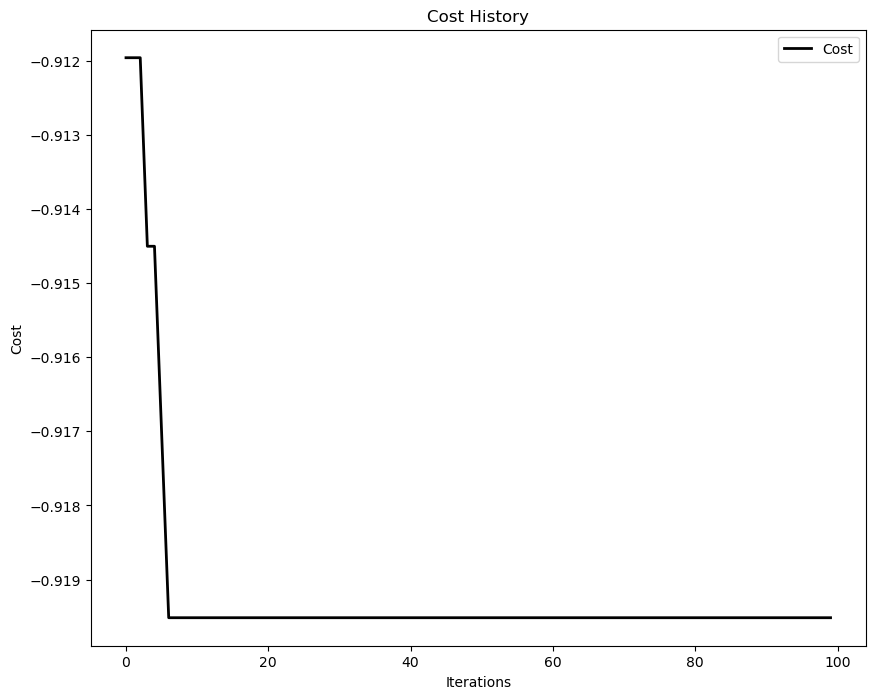

In [359]:
# exibindo a convergência da otimização PSO
plot_cost_history(optimizer.cost_history)
plt.show()

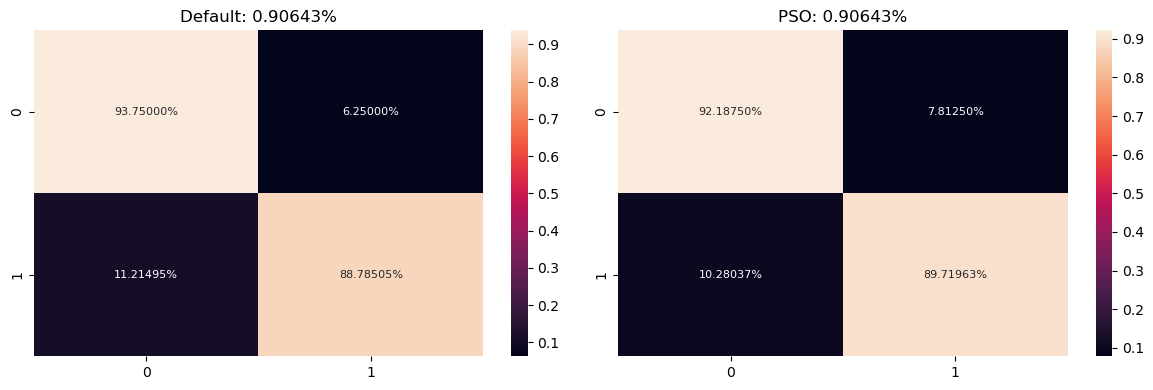

In [357]:
# exibindo a matriz de confusão de teste default e PSO
def plot_heatmap(y, y_pred, title):
    cm = confusion_matrix(y, y_pred, normalize="true")
    plot = sns.heatmap(cm, annot=True, fmt=".5%", annot_kws={'fontsize': 8})
    plot.set_title(title + ": " + str(accuracy_score(y, y_pred).round(5)) + "%")
    
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_heatmap(y_test, y_test_pred_default, 'Default')
plt.subplot(1, 2, 2)
plot_heatmap(y_test, y_test_pred_pso, 'PSO')

plt.tight_layout() 
plt.show()

### Resultados e considerações

Foram realizados alguns experimentos variando o tamanho do conjunto de treinamento e teste e alterando as configurações do PSO:

#### dados = 70% treino e 30% teste, n_particles = 20 e iters = 100
- Melhores hps para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.3873037  0.33216977 0.40259702]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.91951
- Acurácia de teste do algotirmo decision tree (default):  0.90643
- Acurácia de teste do algotirmo decision tree (PSO):  0.90643

#### dados = 80% treino e 20% teste, n_particles = 20 e iters = 100
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.68341878 0.40563693 0.12104335]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.91863
- Acurácia de teste do algotirmo decision tree (default):  0.92105
- Acurácia de teste do algotirmo decision tree (PSO):  0.89474

#### dados = 60% treino e 40% teste, n_particles = 20 e iters = 100
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.40165354 0.40046065 0.3853279 ]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.92662
- Acurácia de teste do algotirmo decision tree (default):  0.92105
- Acurácia de teste do algotirmo decision tree (PSO):  0.89035

#### dados = 50% treino e 50% teste, n_particles = 20 e iters = 100
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.26540866 0.31016183 0.40346789]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.90142
- Acurácia de teste do algotirmo decision tree (default):  0.93333
- Acurácia de teste do algotirmo decision tree (PSO):  0.90175

#### dados = 90% treino e 10% teste, n_particles = 20 e iters = 100
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.57221409 0.37887374 0.38845903]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.91597
- Acurácia de teste do algotirmo decision tree (default):  0.85965
- Acurácia de teste do algotirmo decision tree (PSO):  0.91228

#### dados = 70% treino e 30% teste, n_particles = 10 e iters = 50
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.67857008 0.40224887 0.31782886]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.91951
- Acurácia de teste do algotirmo decision tree (Default):  0.90643
- Acurácia de teste do algotirmo decision tree (PSO):  0.90643

#### dados = 80% treino e 20% teste, n_particles = 30 e iters = 90
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.59166984 0.40295813 0.34257047]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.91863
- Acurácia de teste do algotirmo decision tree (default):  0.92105
- Acurácia de teste do algotirmo decision tree (PSO):  0.89474

#### dados = 60% treino e 40% teste, n_particles = 10 e iters = 10
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.32539936 0.39774876 0.31995219]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.92662
- Acurácia de teste do algotirmo decision tree (default):  0.92105
- Acurácia de teste do algotirmo decision tree (PSO):  0.89035

#### dados = 50% treino e 50% teste, n_particles = 100 e iters = 200
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.19350942 0.35627874 0.40274757]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.90142
- Acurácia de teste do algotirmo decision tree (default):  0.93333
- Acurácia de teste do algotirmo decision tree (PSO):  0.90175

#### dados = 90% treino e 10% teste, n_particles = 50 e iters = 50
- Melhores HPs para min_samples_split, min_samples_leaf e min_weight_fraction_leaf:  [0.39575721 0.38868408 0.3018682 ]
- Acurácia de treinamento do algotirmo decision tree (default):  1.0
- Acurácia de treinamento do algotirmo decision tree (PSO):  0.91597
- Acurácia de teste do algotirmo decision tree (default):  0.85965
- Acurácia de teste do algotirmo decision tree (PSO):  0.91228

Como o dataset breast_cancer possui poucos dados, notou-se através dos experimentos, que a acurácia de treino e teste varia pouco independente da divisão treino/teste.

Mesmo alterando os números de partículas e iterações, a acurácia permanece a mesma quando as partições de treino/teste são iguais.

Pode-se obervar também que os valores dos melhores hiperparâmentros sempre mudam, porém não melhoram o resultado final (talvez pelo fato dos hiperparâmetros escolhidos para este experimento não serem os mais eficientes diponíveis do algoritmo).

Como experimento futuro, pretende-se oberservar outros hiperparâmetros do algoritmo DecisionTree além de outros classificadores, com o intuito de buscar melhores desempenhos na utilização do PSO.

De maneira geral, o algoritmo DecisionTree com hiperparâmetros default e com o PSO, não trouxe grandes diferenças na acurácia, no entanto, a utilização do PSO deve atingir bons resultados, principalmente utilizados com os hiperparâmetros corretos em cada algoritmo.